# Union tagging system
The *Union_master* is capable of recording histories for each neutron in a tree like fashion and add the total intensities for each unique history together. At the end of the simulation these are sorted by intensity and written to file, and the top 20 are shown in the terminal. This system does not work with MPI, if MPI is used only part of the data is written to disk. The system can take up a large amount of memory when used, so it is disabled per default.

First we set up a simple instrument with sample, container and a layer of cryostat.

In [1]:
from mcstasscript.interface import instr, functions, plotter

In [2]:
instrument = instr.McStas_instr("python_tutorial", input_path="run_folder")

In [3]:
Al_inc = instrument.add_component("Al_inc", "Incoherent_process")
Al_inc.sigma = 0.0082
Al_inc.unit_cell_volume = 66.4

Al_pow = instrument.add_component("Al_pow", "Powder_process")
Al_pow.reflections = '"Al.laz"'

Al = instrument.add_component("Al", "Union_make_material")
Al.process_string = '"Al_inc,Al_pow"'
Al.my_absorption = 100*0.231/66.4 # barns [m^2 E-28] * Å^3 [m^3 E-30] = [m E-2], correct with factor 100.

Sample_inc = instrument.add_component("Sample_inc", "Incoherent_process")
Sample_inc.sigma = 3.4176
Sample_inc.unit_cell_volume = 1079.1

Sample_pow = instrument.add_component("Sample_pow", "Powder_process")
Sample_pow.reflections = '"Na2Ca3Al2F14.laz"'

Sample = instrument.add_component("Sample", "Union_make_material")
Sample.process_string = '"Sample_inc,Sample_pow"'
Sample.my_absorption = 100*2.9464/1079.1

src = instrument.add_component("source", "Source_div")
src.xwidth = 0.01
src.yheight = 0.035
src.focus_aw = 0.01
src.focus_ah = 0.01
src.lambda0 = instrument.add_parameter("wavelength", value=5.0, comment="Wavelength in [Ang]")
src.dlambda = "0.01*wavelength"
src.flux = 1E13

sample_geometry = instrument.add_component("sample_geometry", "Union_cylinder")
sample_geometry.yheight = 0.03
sample_geometry.radius = 0.0075
sample_geometry.material_string='"Sample"' 
sample_geometry.priority = 100
sample_geometry.set_AT([0,0,1], RELATIVE=src)

container = instrument.add_component("sample_container", "Union_cylinder", RELATIVE=sample_geometry)
container.yheight = 0.03+0.003 # 1.5 mm top and button
container.radius = 0.0075 + 0.0015 # 1.5 mm sides of container
container.material_string='"Al"' 
container.priority = 99

inner_wall = instrument.add_component("cryostat_wall", "Union_cylinder")
inner_wall.set_AT([0,0,0], RELATIVE=sample_geometry)
inner_wall.yheight = 0.12
inner_wall.radius = 0.03
inner_wall.material_string='"Al"' 
inner_wall.priority = 80

inner_wall_vac = instrument.add_component("cryostat_wall_vacuum", "Union_cylinder")
inner_wall_vac.set_AT([0,0,0], RELATIVE=sample_geometry)
inner_wall_vac.yheight = 0.12 - 0.008
inner_wall_vac.radius = 0.03 - 0.002
inner_wall_vac.material_string='"Vacuum"' 
inner_wall_vac.priority = 81

logger_zx = instrument.add_component("logger_space_zx", "Union_logger_2D_space", RELATIVE=sample_geometry)
logger_zx.D_direction_1 = '"z"'
logger_zx.D1_min = -0.04
logger_zx.D1_max = 0.04
logger_zx.n1 = 300
logger_zx.D_direction_2 = '"x"'
logger_zx.D2_min = -0.04
logger_zx.D2_max = 0.04
logger_zx.n2 = 300
logger_zx.filename = '"logger_zx.dat"'

logger_zy = instrument.add_component("logger_space_zy", "Union_logger_2D_space", RELATIVE=sample_geometry)
logger_zy.D_direction_1 = '"z"'
logger_zy.D1_min = -0.04
logger_zy.D1_max = 0.04
logger_zy.n1 = 300
logger_zy.D_direction_2 = '"y"'
logger_zy.D2_min = -0.06
logger_zy.D2_max = 0.06
logger_zy.n2 = 300
logger_zy.filename = '"logger_zy.dat"'

### Adding the Union_master with tagging
There are two important parameters to consider when setting a *Union_master* up for tagging:
- enable_tagging [default 0] 0 for disable, 1 for enable
- history_limit [default 300000] Limit of unique histories recorded

As the *Union_master* component records each ray in succession, their unique history is added to the history tree. If a ray takes the same path in the tree, the intensity gets added to that unique history. When the history limit is reached, the tree is not built out further, but if already recorded histories occur, their intensity is still added to the existing tree.

In [4]:
master = instrument.add_component("master", "Union_master")
master.enable_tagging = 1
master.history_limit = 300000

In [5]:
instrument.set_parameters(wavelength=3.0)
instrument.settings(ncount=3E5, output_path="data_folder/union_tagging")

instrument.backengine()
data = instrument.data

INFO: Using directory: "/Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/docs/source/tutorial/data_folder/union_tagging_3"
INFO: Regenerating c-file: python_tutorial.c
CFLAGS= -I@MCCODE_LIB@/share/
INFO: Recompiling: ./python_tutorial.out
mccode-r.c:2837:3: warning: expression result unused [-Wunused-value]
  *t0;
  ^~~
In file included from /Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//contrib/union/Incoherent_process.comp:65:
/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//share/Union_functions.c:1604:105: warning: incompatible pointer types passing 'int (const struct saved_history_struct *, const struct saved_history_struct *)' to parameter of type 'int (* _Nonnull)(const void *, const void *)' [-Wincompatible-pointer-types]
  qsort(total_history.saved_histories,total_history.used_elements,sizeof (struct saved_history_struct), Sample_compare_history_intensities);
                                                                           

Plotting data with name logger_space_zx
Plotting data with name logger_space_zy


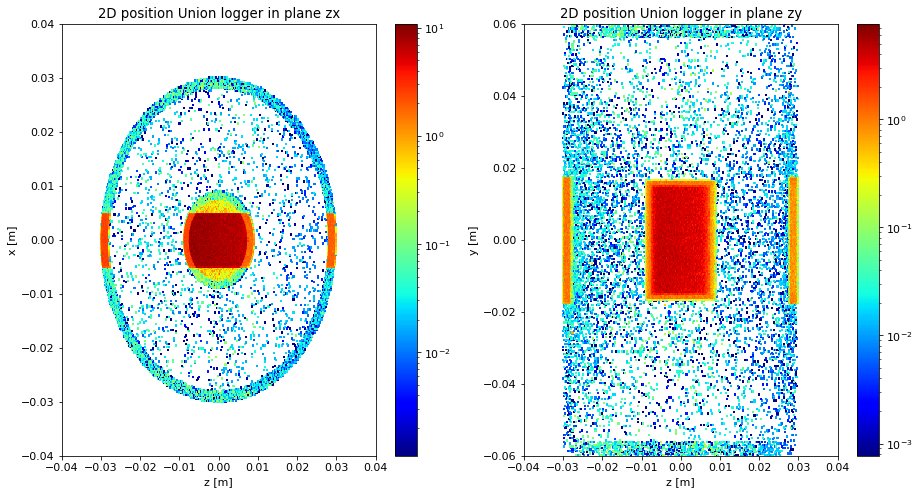

In [6]:
functions.name_plot_options("logger_space_zx", data, log=True, orders_of_mag=4)
functions.name_plot_options("logger_space_zy", data, log=True, orders_of_mag=4)
plotter.make_sub_plot(data)

### Finding the history file
A file called Union_history.dat is written in the run folder with all the unique histories. In some cases a bug happens that causes the file to be unreadable, for now the best fix is to rerun the simulation.

In [7]:
with open("run_folder/Union_history.dat") as file:
    instrument_string = file.read()
    print(instrument_string)

History file written by the McStas component Union_master 
When running with MPI, the results may be from just a single thread, meaning intensities are divided by number of threads
----- Description of the used volumes -----------------------------------------------------------------------------------
V0: Surrounding vacuum 
V1: sample_geometry  Material: Sample   P0:  P1: Sample_pow
V2: sample_container  Material: Al   P0: 4 P1: Al_pow
V3: cryostat_wall  Material: Al   P0: 4 P1: Al_pow
V4: cryostat_wall_vacuum  Material: Vacuum  
----- Histories sorted after intensity ----------------------------------------------------------------------------------
1859607	 N I=3.965281E+04 	 V0 -> V3 -> V4 -> V2 -> V1 -> V2 -> V4 -> V3 -> V0 
506763	 N I=1.050335E+04 	 V0 -> V3 -> V4 -> V2 -> V1 -> P1 -> V2 -> V4 -> V3 -> V0 
226314	 N I=4.825743E+03 	 V0 -> V3 -> V4 -> V2 -> V4 -> V3 -> V0 
166837	 N I=3.557502E+03 	 V0 -> V3 -> V4 -> V3 -> V0 
70469	 N I=1.466246E+03 	 V0 -> V3 -> V4 -> V2 -> V1 -

### Interpreting the histories
The history with highest intensity in my run is: V0 -> V3 -> V4 -> V2 -> V1 -> V2 -> V4 -> V3 -> V0, which means:
- Neutron entered Volume0 (Surrounding vacuum)
- Neutron entered Volume3 (Cryostat wall)
- Neutron entered Volume4 (Cryostat vacuum)
- Neutron entered Volume2 (Container)
- Neutron entered Volume1 (Sample)
- Neutron entered Volume2 (Container)
- Neutron entered Volume4 (Cryostat vacuum)
- Neutron entered Volume3 (Cryostat wall)
- Neutron entered Volume0 (Surrounding vacuum)

So the most likely occurrence is that the ray is propagated through all geometries. The next most likely history is:

V0 -> V3 -> V4 -> V2 -> V1 -> P1 -> V2 -> V4 -> V3 -> V0

- Neutron entered Volume0 (Surrounding vacuum)
- Neutron entered Volume3 (Cryostat wall)
- Neutron entered Volume4 (Cryostat vacuum)
- Neutron entered Volume2 (Container)
- Neutron entered Volume1 (Sample)
- Neutron scattered on Process1 (Since we are in Volume1, that would be Sample_pow)
- Neutron entered Volume2 (Container)
- Neutron entered Volume4 (Cryostat vacuum)
- Neutron entered Volume3 (Cryostat wall)
- Neutron entered Volume0 (Surrounding vacuum)

## Use conditional component to filter tagging
Just like a logger can be modified by a conditional component to only record events that satisfy that condition, the tagging system of the *Union_master* component can also be modified by a conditional component. In that case, the tagging system will only record events that satisfy the condition imposed by the conditional component.

This can be useful to explain an unexpected feature, as the conditional components can filter for energy, time, direction or any combination of these. Here we demonstrate this feature by adding a *Union_conditional_PSD* outside of the direct beam and enabling the *master_tagging* control parameter, which causes the condition to be applied to the tagging system.

In [8]:
# Set up an arm pointing to the relevant spot
spot_dir = instrument.add_component("spot_dir", "Arm", RELATIVE=sample_geometry, before="master")
spot_dir.set_ROTATED([0, 60, 0], RELATIVE=sample_geometry)

# Set up a conditional component targeting all our loggers
PSD_conditional = instrument.add_component("space_all_PSD_conditional", "Union_conditional_PSD", before="master")
PSD_conditional.xwidth = 0.2
PSD_conditional.yheight = 0.2
PSD_conditional.master_tagging = 1
PSD_conditional.set_AT([0, 0, 0.5], RELATIVE=spot_dir) 

In [9]:
instrument.backengine()
data = instrument.data

INFO: Using directory: "/Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/docs/source/tutorial/data_folder/union_tagging_4"
INFO: Regenerating c-file: python_tutorial.c
CFLAGS= -I@MCCODE_LIB@/share/
INFO: Recompiling: ./python_tutorial.out
mccode-r.c:2837:3: warning: expression result unused [-Wunused-value]
  *t0;
  ^~~
In file included from /Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//contrib/union/Incoherent_process.comp:65:
/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//share/Union_functions.c:1604:105: warning: incompatible pointer types passing 'int (const struct saved_history_struct *, const struct saved_history_struct *)' to parameter of type 'int (* _Nonnull)(const void *, const void *)' [-Wincompatible-pointer-types]
  qsort(total_history.saved_histories,total_history.used_elements,sizeof (struct saved_history_struct), Sample_compare_history_intensities);
                                                                           

In [10]:
with open("run_folder/union_history.dat") as file:
    instrument_string = file.read()
    print(instrument_string)

History file written by the McStas component Union_master 
When running with MPI, the results may be from just a single thread, meaning intensities are divided by number of threads
----- Description of the used volumes -----------------------------------------------------------------------------------
V0: Surrounding vacuum 
V1: sample_geometry  Material: Sample   P0:  P1: Sample_pow
V2: sample_container  Material: Al   P0:  P1: Al_pow
V3: cryostat_wall  Material: Al   P0:  P1: Al_pow
V4: cryostat_wall_vacuum  Material: Vacuum  
----- Histories sorted after intensity ----------------------------------------------------------------------------------
5892	 N I=4.578027E+01 	 V0 -> V3 -> V4 -> V2 -> V1 -> P1 -> V2 -> V4 -> V3 -> V0 
895	 N I=2.001013E+01 	 V0 -> V3 -> V4 -> V2 -> V1 -> P1 -> P1 -> V2 -> V4 -> V3 -> V0 
143	 N I=3.463667E+00 	 V0 -> V3 -> V4 -> V2 -> V1 -> P1 -> P1 -> P1 -> V2 -> V4 -> V3 -> V0 
108	 N I=2.251620E+00 	 V0 -> V3 -> V4 -> V2 -> V1 -> P0 -> V2 -> V4 -> V3 -> 

### Interpreting the data
Now all the histories contain a scattering process as this is necessary to reach the rectangle placed by the Union_conditional_PSD component set at 2theta = 60 deg. We also observe the intensities are much lower, simply because only a fraction of the simulated rays satisfy this condition.